In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set()

In [ ]:
# Load data 
train_values = pd.read_csv('',index_col='sequence_id')

In [ ]:
train_label = pd.read_csv('',index_col='sequence_id')

In [ ]:
test_values= pd.read_csv('',index_col='sequence_id')

In [ ]:
sequence_length = train_values['sequence'].apply(len)
sequence_length.describe()


count    63017.000000
mean      4839.025501
std       3883.148431
min         20.000000
25%        909.000000
50%       4741.000000
75%       7490.000000
max      60099.000000
Name: sequence, dtype: float64

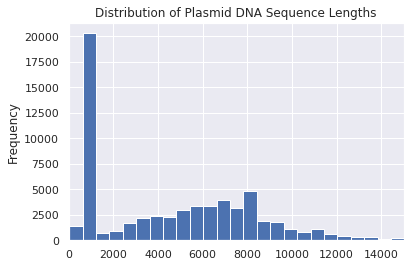

In [ ]:
sequence_length.plot(kind='hist',title='Distribution of Plasmid DNA Sequence Lengths',
                     bins=100,
                     xlim=(0,15000));
# Right-skewed

In [ ]:
sequence_length.skew()

1.1334314808584518

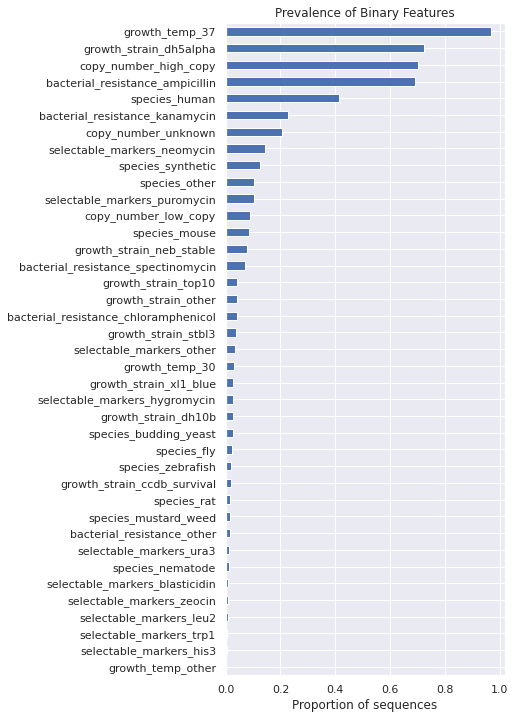

In [ ]:
# Get prevalence of sequence for each characteristic using mean 

sorted_binary_features = train_values.iloc[:,1:].mean().sort_values()

ax = sorted_binary_features.plot(kind='barh',stacked=True,figsize=(5,12),
                                 title='Prevalence of Binary Features')

ax.set_xlabel('Proportion of sequences');

In [ ]:
test_values['sequence'].apply(len).describe()

count    18816.000000
mean      4875.523810
std       4004.117614
min         19.000000
25%        894.750000
50%       4732.000000
75%       7341.250000
max      38638.000000
Name: sequence, dtype: float64

In [ ]:
train_label.head()

,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,0CML4B5I,0DTHTJLJ,0FFBBVE1,0HWCWFNU,0L3Y6ZB2,0M44GDO8,0MDYJM3H,0N3V9P9M,0NP55E93,0PJ91ZT6,0R296F9R,0T2AZBD6,0URA80CN,0VRP2DI6,0W6O08VX,0WHP4PPK,0XPTGGLP,0XS4FHP3,0Y24J5G2,10TEBWK2,11TTDKTM,131RRHBV,13LZE1F7,14PBN8C2,15D0Z97U,15S88O4Q,18C9J8EH,19CAUKJB,1AP294AT,1B9BJ2IP,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9ZIMC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# get the column with the max value in each row
lab_ids = pd.DataFrame(train_label.idxmax(axis=1), columns=['lab_id'])
lab_ids.head()

,lab_id
sequence_id,
9ZIMC,RYUA3GVO
5SAQC,RYUA3GVO
E7QRO,RYUA3GVO
CT5FP,RYUA3GVO
7PTD8,RYUA3GVO


# Use the DNA sequences as the basis for the features in our model. 


These sequences are composed of five characters. 
G, C, A, and T represent the four nucleotides commonly found in DNA (guanine, cytosine, adenine, thymine).
N stand for any nucleotide (not a gap).

In [ ]:
bases = set(''.join(train_values['sequence'].values))
bases

{'A', 'C', 'G', 'N', 'T'}

In [ ]:
# Use ngrams to turn diff strings combination 
# of bases into features
# we'll split up the DNA sequences into four-grams, or 4 bases.
# With 5 unique bases, we can produce 
# 120 different sequence permutations consisting of 4 bases. 

In [ ]:
from itertools import permutations
n = 4 
subsequences = [''.join(permutation) for permutation in permutations(bases,r=n)]


In [ ]:
print(f"Number of sequences: {len(subsequences)}")
subsequences[:5]

Number of sequences: 120


['CGAT', 'CGAN', 'CGTA', 'CGTN', 'CGNA']

In [ ]:
# Use count of non over-lapping strings to create new features 
def get_ngram_features(data, subsequences):
  """Generate count for each subsequence.
  args: 
      data (DF): the data you want to create features from
      subsequences (list):  a list of subsequences to count
  returns:
      DF: A df with one column for each subsequence.
  """
  features = pd.DataFrame(index=data.index)
  for subseq in subsequences:
    features[subseq] = data.sequence.str.count(subseq)
  return features 

In [ ]:
ngram_features = get_ngram_features(train_values,subsequences)
# ngram_features.head()

In [ ]:
ngram_features.shape

(63017, 120)

In [ ]:
# now that we have features for all 120 possible combination
# we join them with our binary features 

all_features = ngram_features.join(train_values.drop('sequence',axis=1))

In [ ]:
# all_features.head()

In [ ]:
all_features.shape

(63017, 159)

In [ ]:
# Construct custom top-k accuracy scorer 
# Using Scikit-Learn defined approach 
https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

###Construct custom top-k accuracy scorer. The goal here is to narrow down the list of possible labs of origin and evaluate model performance based on top-ten accuracy i.e we consider a prediction correct if the true-lab of origin is in the top ten most likely labs 
###Using Scikit-Learn defined approach 

---



---


https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

In [ ]:
def top10_accuracy_scorer(estimator, X, y):
  """A custom scorer that evaluates a model on whether the correct label is in 
    the top 10 most probable predictions.

    Args:
        estimator (sklearn estimator): The sklearn model that should be evaluated.
        X (numpy array): The validation data.
        y (numpy array): The ground truth labels.

    Returns:
        float: Accuracy of the model as defined by the proportion of predictions
               in which the correct label was in the top 10. Higher is better.
  """

   # predict the probabilities across all possible labels for rows in our training set
  probas = estimator.predict_proba(X)
    
    # get the indices for top 10 predictions for each row; these are the last ten in each row
    # Note: We use argpartition, which is O(n), vs argsort, which uses the quicksort algorithm 
    # by default and is O(n^2) in the worst case. We can do this because we only need the top ten
    # partitioned, not in sorted order.
    # Documentation: https://numpy.org/doc/1.18/reference/generated/numpy.argpartition.html
  top10_idx = np.argpartition(probas, -10, axis=1)[:, -10:]
    
  # index into the classes list using the top ten indices to get the class names
  top10_preds = estimator.classes_[top10_idx]

  # check if y-true is in top 10 for each set of predictions
  mask = top10_preds == y.reshape((y.size, 1))
  
  # take the mean
  top_10_accuracy = mask.any(axis=1).mean()

  return top_10_accuracy

In [ ]:
#  First model attempt using Random Forest 

from sklearn.ensemble import RandomForestClassifier

# use features array for X 
X = all_features
# Use labs IDs labels as y 
y = lab_ids.values.ravel()

In [ ]:
# Train Random Forest model for a start 
# The dataset has higly imbalanced classes 
# so we use weight decay to keep it inversely proportional to frequency 

rf = RandomForestClassifier(n_jobs=4,
                            n_estimators=150, 
                            class_weight='balanced',
                            max_depth=3,
                            random_state=10)
# fit a model 
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
                       oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
rf.score(X,y)

0.1884729517431804

In [ ]:
top10_accuracy_scorer(rf,X,y)

0.3794690321659235

In [ ]:
test_ngram_features = get_ngram_features(test_values,subsequences)
all_test_features = test_ngram_features.join(test_values.drop('sequence',axis=1))

In [ ]:
probas = rf.predict_proba(all_test_features)
probas[0]

array([0.00089113, 0.0010265 , 0.00101658, ..., 0.00092799, 0.00026896,
       0.00020879])

#### Use calibrated probabilities because of the class imbalance problem, including a grid search of different probability calbiration methods to avoid over-confidence in the models.

Calibration is the concordance of predicted probabilities with the occurrence of positive cases https://en.wikipedia.org/wiki/Calibration_(statistics)

Many algorithms either predict a probability-like score or a class label and must be coerced in order to produce a probability-like score. As such, an algorithm like SVM or Decision Trees often require their “probabilities” to be calibrated prior to use.

Probability predictions are made on training data and the distribution of probabilities is compared to the expected probabilities and adjusted to provide a better match. This often involves splitting a training dataset and using one portion to train the model and another portion as a validation set to scale the probabilities.

Here we use Platt Scalling to scale the output from a SVM to probability values 

In [ ]:
# evaluate svm with calibrated probabilities for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

In [ ]:
# evaluate svm with calibrated probabilities for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

In [14]:

# define model
model = SVC(gamma='scale')
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
top10_accuracy_scorer(cv,X,y)